In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
import sys
sys.path.append('./src')
from funcs import *
# Random Search CV tends to be better

In [2]:
if not os.path.exists('./results'):
    os.makedirs('./results')

## Training a Random Forest Model

## Table of Contents:
* [Loading Preprocessed Data](#first-bullet)
* [Training an Estimator](#second-bullet)
* [Hyperparameter Tuning](#third-bullet)
* [Hyperparameter Tuning for Lasso](#fourth-bullet)
* [Further Exploration of Output Data](#fifth-bullet)
* [Saving Data](#sixth-bullet)

## Loading Preprocessed Data <a class="anchor" id="first-bullet"></a>

In [3]:
import os
# binary data is used for the Lasso Model
categorical_binary = pd.read_csv(r'./preprocessed/categorical_binary.csv', index_col =0)
categorical_raw = pd.read_csv(r'./preprocessed/categorical_raw.csv', index_col =0)
regression_data = pd.read_csv(r'./preprocessed/regression_transformed.csv', index_col =0)
regression_cols = regression_data.columns
index = pd.read_csv('./preprocessed/benchmark_datasets_index.csv', index_col =0)
price = pd.read_csv('./preprocessed/price.csv', index_col =0)

In [4]:
regression_cols = ['host_response_rate', 'host_acceptance_rate',
       'transformed_review_scores_rating',
       'transformed_review_scores_accuracy',
       'transformed_review_scores_cleanliness',
       'transformed_review_scores_checkin',
       'transformed_review_scores_communication',
       'transformed_review_scores_location',
       'transformed_review_scores_value']
# note remove bathrooms text as a predictor

In [5]:
X_train, X_test, X_val, y_train, y_test, y_val = create_training_dataset(categorical_raw, regression_data,
                                                                         price, index, regression_cols,
                                                                         norm_reg = True)

In [6]:
categorical_binary.dropna()

,host_identity_verified_0,host_identity_verified_1,accommodates_0,accommodates_1,accommodates_2,accommodates_3,accommodates_4,accommodates_5,accommodates_6,accommodates_7,...,neighbourhood_group_cleansed_3,neighbourhood_group_cleansed_4,host_has_profile_pic_0,host_has_profile_pic_1,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_is_superhost_0,host_is_superhost_1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19990,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
19991,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
19994,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
19996,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Training an Estimator <a class="anchor" id="second-bullet"></a>

In [7]:
rf = RandomForestRegressor(max_features =5, max_depth =10)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=5)

<AxesSubplot:>

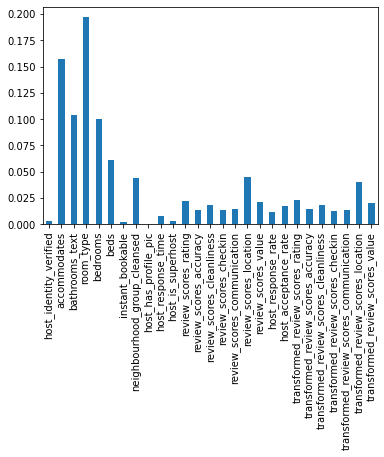

In [8]:
df_feature = pd.DataFrame(data = rf.feature_importances_, index = X_train.columns)
df_feature[0].plot.bar()

In [9]:
val_metrics, y_hat_val = eval_metrics(X_val, y_val, rf)
test_metrics, y_hat_val = eval_metrics(X_test, y_test, rf)
val_metrics.to_csv('./results/RF_val.csv')
test_metrics.to_csv('./results/RF_test.csv')

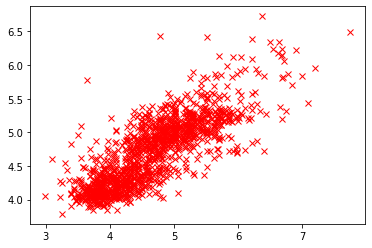

In [10]:
fig, ax = plt.subplots()
ax.plot(y_hat_val.log_price,y_hat_val.predictions,'rx')

# Hyperparameter Tuning <a class="anchor" id="third-bullet"></a>
1. Creating a set of paramters to loop over for the random forest estimator

In [11]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [12]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 50, cv = 5, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
best_rf = rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [13]:
val_metrics, y_hat_val = eval_metrics(X_val, y_val, best_rf)
test_metrics, y_hat_test = eval_metrics(X_test, y_test, best_rf)
val_metrics.to_csv('./results/RF_hyperparameter_val.csv')
test_metrics.to_csv('./results/RF_hyparameter_test.csv')

# Hyperparameter Tuning for Lasso <a class="anchor" id="fourth-bullet"></a>
1. Creating a set of paramters to loop over for the random forest estimator

In [14]:
X_train, X_test, X_val, y_train, y_test, y_val = create_training_dataset(categorical_binary, regression_data,
                                                                         price, index, regression_cols,
                                                                         norm_reg = True)

In [15]:
random_grid = {'alpha': np.logspace(-6, 1,25)}
cls = Lasso(alpha =0.1)
cls_random = RandomizedSearchCV(estimator = cls, param_distributions = random_grid,
                               n_iter = 15, cv = 5, verbose=1, random_state=42, n_jobs = -1)
cls_best = cls_random.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [16]:
val_metrics, y_hat_val = eval_metrics(X_val, y_val, cls_best)
test_metrics, y_hat_test = eval_metrics(X_test, y_test, cls_best)
test_metrics

0
log_corrcoef      0.811661
corrcoef          0.688332
rmse            108.750615
log_rmse          0.422964
Name: 1, dtype: float64

In [17]:
val_metrics.to_csv('./results/Lasso_hyperparameter_val.csv')
test_metrics.to_csv('./results/Lasso_hyparameter_test.csv')